In [200]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Imports
import itertools
import pickle

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

# 0) Load
---

In [2]:
training_set = pd.read_csv('train_V2.csv')
test_set = pd.read_csv('test_V2.csv')
sample = pd.read_csv('sample_submission_V2.csv')

# 1) Feature Engineering
***

In [3]:
print('Features: ')
print(training_set.columns.values)

Features: 
['Id' 'groupId' 'matchId' 'assists' 'boosts' 'damageDealt' 'DBNOs'
 'headshotKills' 'heals' 'killPlace' 'killPoints' 'kills' 'killStreaks'
 'longestKill' 'matchDuration' 'matchType' 'maxPlace' 'numGroups'
 'rankPoints' 'revives' 'rideDistance' 'roadKills' 'swimDistance'
 'teamKills' 'vehicleDestroys' 'walkDistance' 'weaponsAcquired'
 'winPoints' 'winPlacePerc']


>## a) Create some new features

In [4]:
#Strip fpp/tpp off of matchType
def strip(row):    
    if 'normal-' in row:
        if '-fpp' in row:
            return row[7:-4]
        else:
            return row[7:]
    elif '-fpp' in row:
        return row[:-4]
    elif 'fpp' in row or 'tpp' in row:
        return row[:-3]
    else:
        return row

def create_features(dataframe):
    #create a flag for fpp
    dataframe['fppFlag'] = dataframe['matchType'].apply(lambda x: 1 if 'fpp' in x else 0)
    
    #create a players in match feature
    dataframe['playersInMatch'] = dataframe.groupby('matchId')['matchId'].transform('count')
    
    #strip matchType
    dataframe['matchTypeStriped'] = dataframe['matchType'].apply(strip)

> ## b) Encode matchType

In [5]:
#Call strip and encode match type
def encode_matchtype(dataframe):
    #Encode matchType
    enc = OneHotEncoder(sparse=False)
    label = LabelEncoder()
    labeled_matchType = label.fit_transform(dataframe['matchTypeStriped'].values)
    dataframe[['crash', 'duo', 'flare', 'solo', 'squad']] = \
        pd.DataFrame(enc.fit_transform(labeled_matchType.reshape(-1,1)), 
        columns=label.classes_, index=dataframe.index)


In [6]:
create_features(training_set)
encode_matchtype(training_set)
train = training_set

# 2) Inspect Data
---

> ## a) Check for nulls

In [7]:
#First step, any NaNs, etc.?
train[train.isnull().any(axis=1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPoints,winPlacePerc,fppFlag,playersInMatch,matchTypeStriped,crash,duo,flare,solo,squad
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,NaN,1,1,solo,0.0,0.0,0.0,1.0,0.0


In [8]:
#Yep, remove it
train.drop(2744604, inplace=True)

> ## b) Check correlations

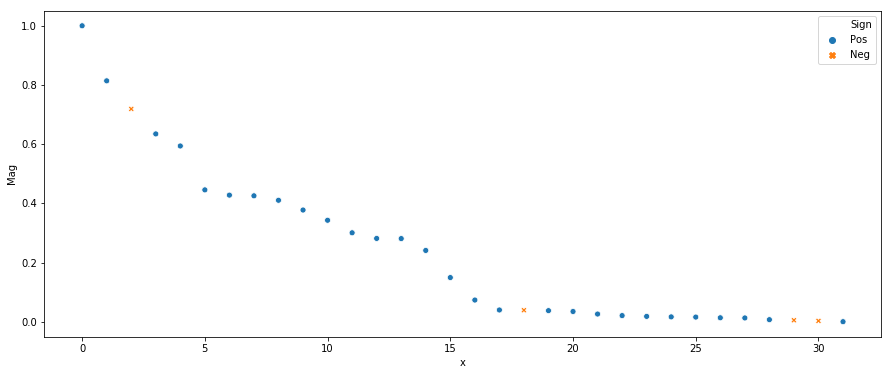

['winPlacePerc' 'walkDistance' 'killPlace' 'boosts' 'weaponsAcquired'
 'damageDealt' 'heals' 'kills' 'longestKill' 'killStreaks' 'rideDistance'
 'assists' 'DBNOs' 'headshotKills' 'revives' 'swimDistance'
 'vehicleDestroys' 'numGroups' 'squad' 'maxPlace' 'roadKills' 'duo' 'solo'
 'playersInMatch' 'fppFlag' 'teamKills' 'rankPoints' 'killPoints'
 'winPoints' 'matchDuration' 'flare' 'crash']


In [117]:
#Start by looking at how the features are correlated with the target

correlations = train.corr()['winPlacePerc']
corr_ranked = pd.DataFrame(np.transpose([np.abs(correlations.values), correlations.apply(lambda x: 'Neg' if x<0 else 'Pos').values])
                           , columns=['Mag','Sign'], index=correlations.index.values)
plot_corrs = corr_ranked.sort_values('Mag', ascending=False)
plot_corrs['x'] = np.arange(plot_corrs.shape[0])

fig = plt.figure(figsize=(15,6))
ax = sns.scatterplot(x='x',y='Mag',hue='Sign', style='Sign', data=plot_corrs, )
#ax.set(xticklabels=plot_corrs.index.values)
plt.show()
print(plot_corrs.index.values)

Two components explain 99.1% of the variance:
    Comp 1 explained variance:  68.57737188824282
    Comp 2 explained variance:  30.66316389541546


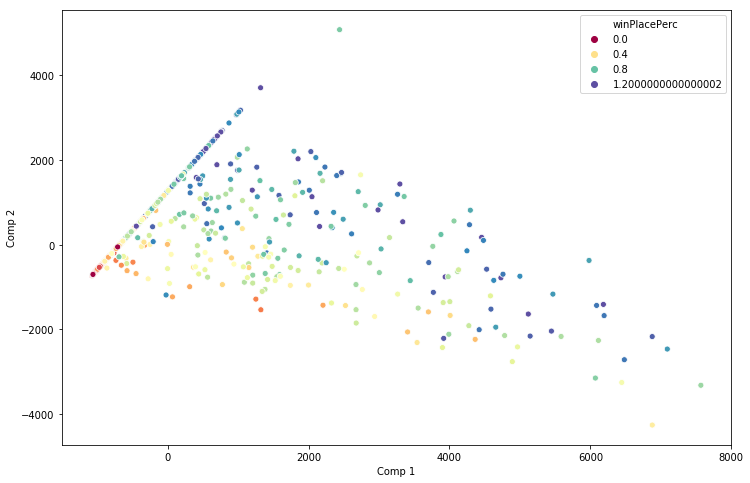

In [150]:
#Lets start by just looking at the most strongly correlated (top 16)
features = plot_corrs.index.values[1:16]
target = 'winPlacePerc'

plotdata = train.head(1000)

#What do these relationships actually look like???
#Use decomposition to view the data

decomp = PCA(2)
decomposed = decomp.fit_transform(plotdata[features])
print('Two components explain 99.1% of the variance:')
print('    Comp 1 explained variance: ',decomp.explained_variance_ratio_[0]*100)
print('    Comp 2 explained variance: ',decomp.explained_variance_ratio_[1]*100)

fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=decomposed[:,0], y=decomposed[:,1], hue=plotdata[target], palette='Spectral')
ax.set(xlabel='Comp 1', ylabel='Comp 2')
plt.show()


Looks pretty linear!

> ## c) Check out the distributions of these features

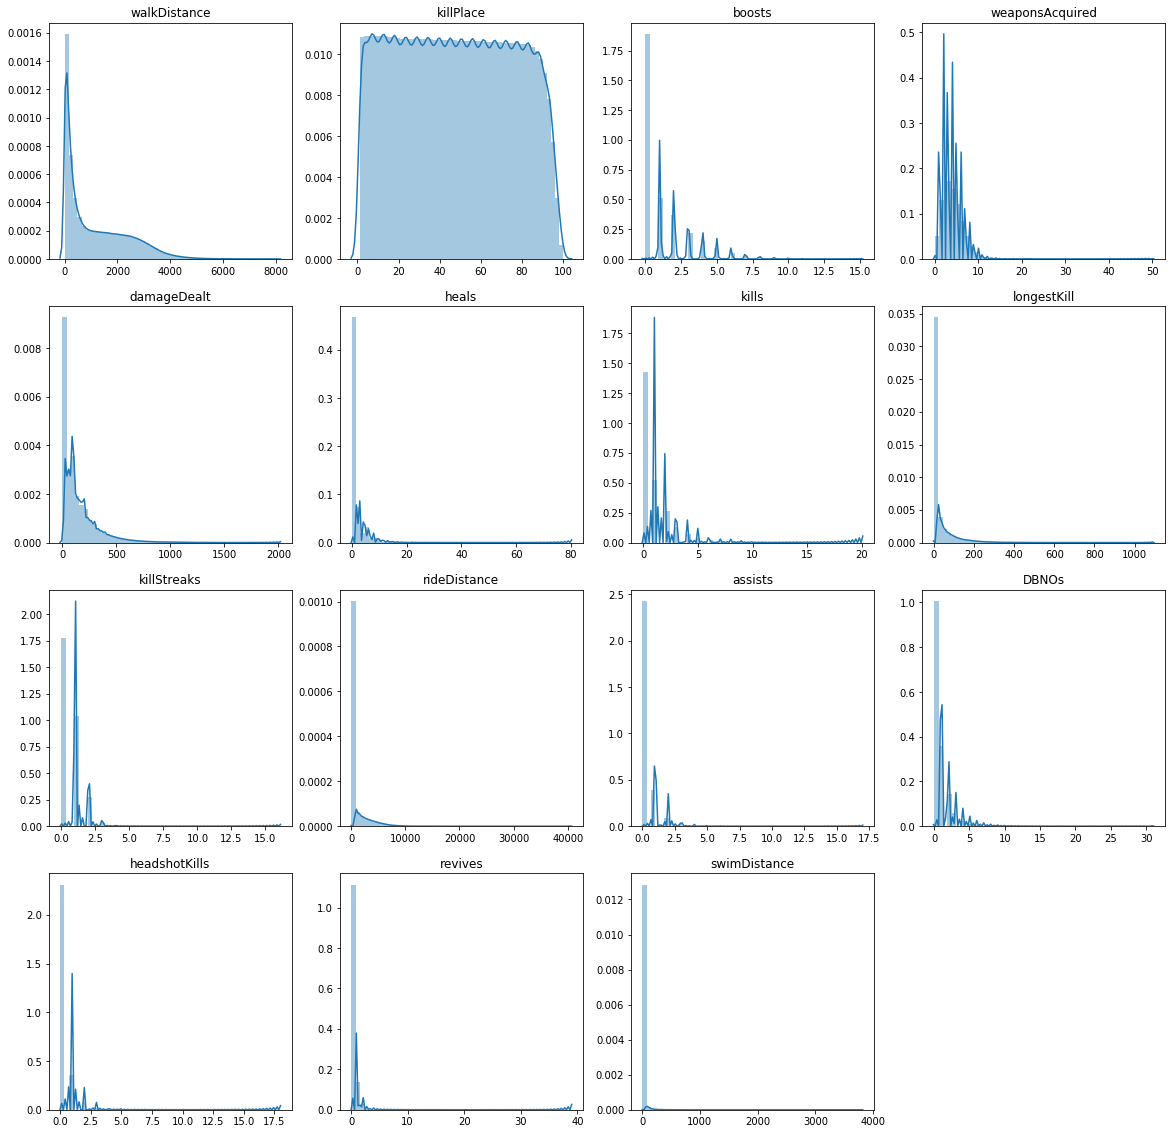

In [151]:
i=1
plt.figure(figsize=(20,20))
for feat in features:
    ax = plt.subplot(4,4,i)
    sns.distplot(train[feat])
    ax.set_xlabel('')
    ax.set_title(feat)
    i=i+1

> ## d) Clip those outliers

In [32]:
# set some upper limits
def clip_features(dataframe, features, limlist):
    limits = dict(zip(features,limlist))
    for feat in limits:
        train.drop(dataframe[dataframe[feat] > limits[feat]].index, inplace=True)

In [152]:
clip_features(train, features, [8000, 100, 15, 20, 
                                1500, 30, 15, 400,
                                7.5, 20000, 7.5, 15,
                                7.5, 15, 1000])

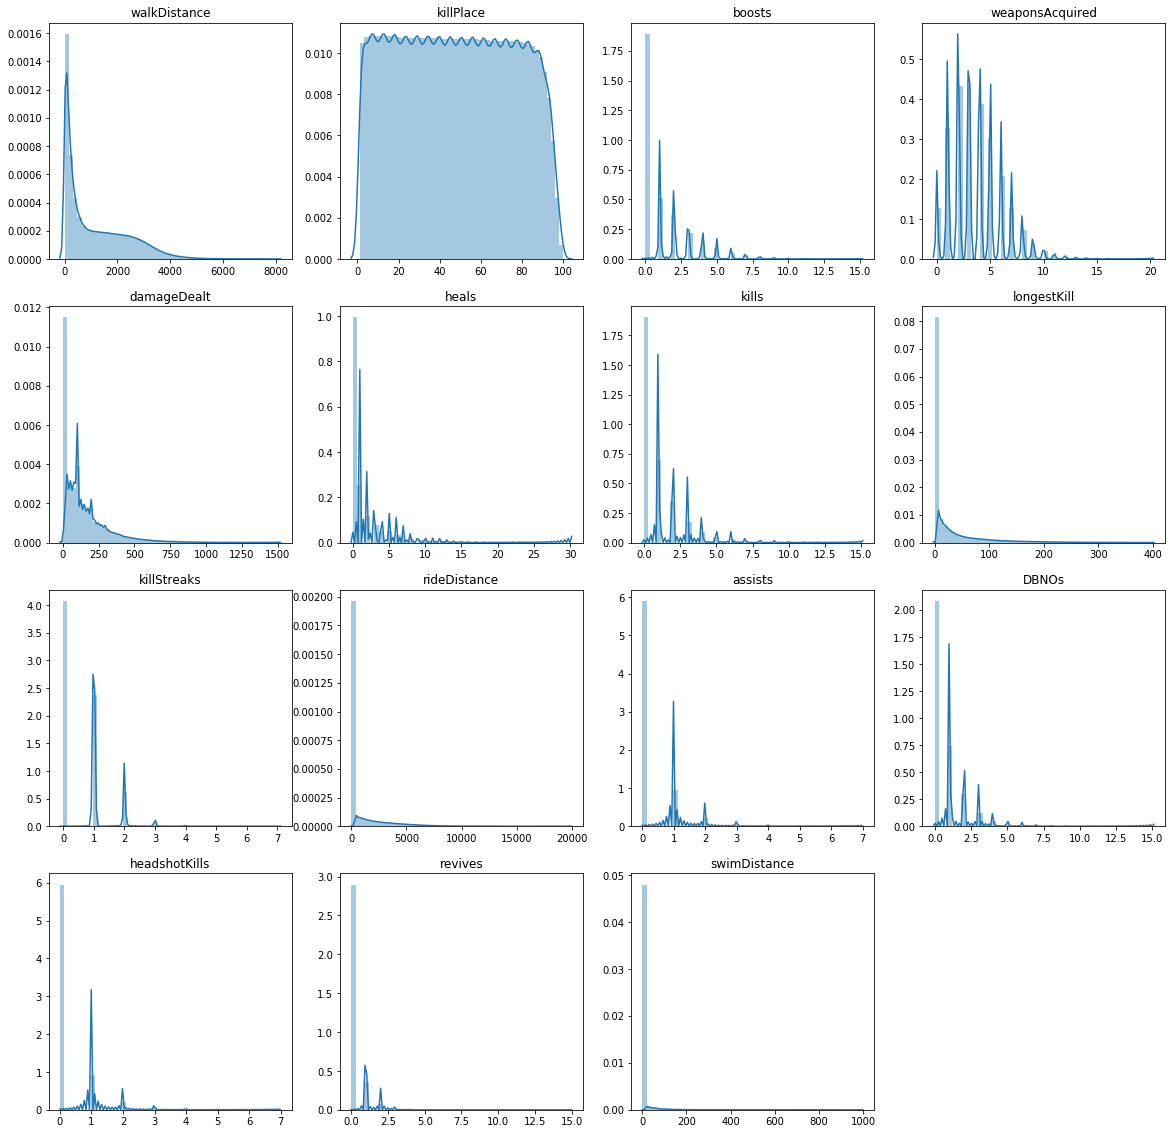

In [153]:
#Check historgrams again
i=1
plt.figure(figsize=(20,20))
for feat in features:
    ax = plt.subplot(4,4,i)
    sns.distplot(train[feat])
    ax.set_xlabel('')
    ax.set_title(feat)
    i=i+1

> ## e) Replot the scatter plots

Two components explain 99.1% of the variance:
    Comp 1 explained variance:  68.65031392056376
    Comp 2 explained variance:  30.638747815877736


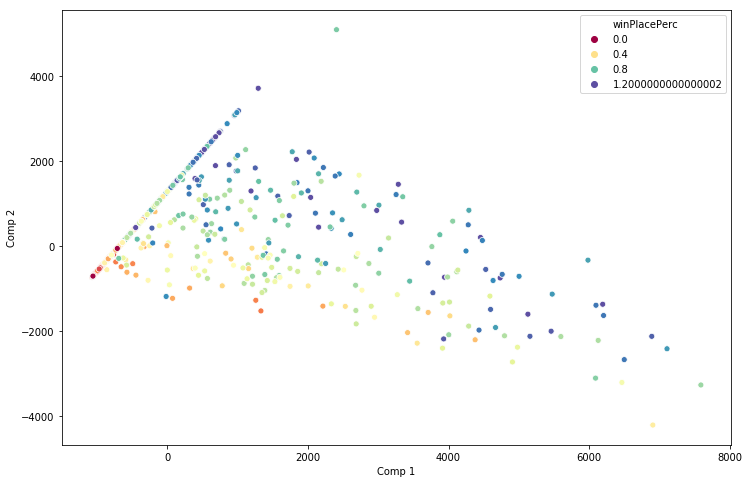

In [154]:
#Replot the scatter plots to see if removing those outliers drastically changed any relationships

plotdata = train.head(1000)

#What do these relationships actually look like???
#Use decomposition to view the data

decomp = PCA(2)
decomposed = decomp.fit_transform(plotdata[features])
print('Two components explain 99.1% of the variance:')
print('    Comp 1 explained variance: ',decomp.explained_variance_ratio_[0]*100)
print('    Comp 2 explained variance: ',decomp.explained_variance_ratio_[1]*100)

fig = plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=decomposed[:,0], y=decomposed[:,1], hue=plotdata[target], palette='Spectral')
ax.set(xlabel='Comp 1', ylabel='Comp 2')
plt.show()

> ## f) Scale the features

In [155]:
train[features].describe()

,walkDistance,killPlace,boosts,weaponsAcquired,damageDealt,heals,kills,longestKill,killStreaks,rideDistance,assists,DBNOs,headshotKills,revives,swimDistance
count,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06
mean,1.149680e+03,4.769614e+01,1.101768e+00,3.636507e+00,1.288154e+02,1.358762e+00,9.073132e-01,2.230223e+01,5.407375e-01,6.023597e+02,2.300599e-01,6.495735e-01,2.208260e-01,1.638625e-01,4.449316e+00
std,1.175187e+03,2.743044e+01,1.707963e+00,2.327583e+00,1.629475e+02,2.636737e+00,1.482612e+00,4.780845e+01,7.063014e-01,1.488244e+03,5.733792e-01,1.105482e+00,5.672598e-01,4.674156e-01,2.941368e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.547000e+02,2.400000e+01,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.817000e+02,4.800000e+01,0.000000e+00,3.000000e+00,8.385000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.971000e+03,7.100000e+01,2.000000e+00,5.000000e+00,1.850000e+02,2.000000e+00,1.000000e+00,2.103000e+01,1.000000e+00,2.140000e-02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.999000e+03,1.000000e+02,1.500000e+01,2.000000e+01,1.500000e+03,3.000000e+01,1.500000e+01,4.000000e+02,7.000000e+00,1.994000e+04,7.000000e+00,1.500000e+01,7.000000e+00,1.500000e+01,9.987000e+02


These features are huge, should scale them down

In [156]:
#scale them down according to number of deviations away from the mean
def scale_features(dataframe, features):
    scaled = dataframe[features].apply(lambda x: (x - x.mean())/(x.std()))
    return scaled

In [157]:
train_scaled = scale_features(train, features)
train_scaled.describe()

,walkDistance,killPlace,boosts,weaponsAcquired,damageDealt,heals,kills,longestKill,killStreaks,rideDistance,assists,DBNOs,headshotKills,revives,swimDistance
count,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06,4.434333e+06
mean,-8.363427e-15,-2.734769e-17,-1.791116e-14,-3.296905e-15,-4.224267e-13,3.076938e-15,-1.325390e-14,-1.098980e-15,1.578374e-15,3.929854e-15,1.581721e-14,1.276711e-14,2.275919e-14,-1.446031e-14,-1.691769e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.782957e-01,-1.702347e+00,-6.450773e-01,-1.562353e+00,-7.905331e-01,-5.153195e-01,-6.119696e-01,-4.664914e-01,-7.655902e-01,-4.047452e-01,-4.012351e-01,-5.875929e-01,-3.892855e-01,-3.505714e-01,-1.512669e-01
25%,-8.466570e-01,-8.638629e-01,-6.450773e-01,-7.030928e-01,-7.905331e-01,-5.153195e-01,-6.119696e-01,-4.664914e-01,-7.655902e-01,-4.047452e-01,-4.012351e-01,-5.875929e-01,-3.892855e-01,-3.505714e-01,-1.512669e-01
50%,-3.982176e-01,1.107748e-02,-6.450773e-01,-2.734626e-01,-2.759502e-01,-5.153195e-01,-6.119696e-01,-4.664914e-01,-7.655902e-01,-4.047452e-01,-4.012351e-01,-5.875929e-01,-3.892855e-01,-3.505714e-01,-1.512669e-01
75%,6.988849e-01,8.495620e-01,5.259082e-01,5.857977e-01,3.448019e-01,2.431938e-01,6.251588e-02,-2.661103e-02,6.502359e-01,-4.047308e-01,-4.012351e-01,3.169898e-01,-3.892855e-01,-3.505714e-01,-1.512669e-01
max,5.828283e+00,1.906782e+00,8.137314e+00,7.030250e+00,8.414886e+00,1.086238e+01,9.505312e+00,7.900230e+00,9.145193e+00,1.299359e+01,1.180709e+01,1.298115e+01,1.195074e+01,3.174078e+01,3.380232e+01


# 3) Set up validation
---

In [191]:
#start with a smaller subset
subset = train_scaled.head(10000)
subset_targets = train[target].head(10000)

#Use a simple 25% hold out for validation
x_train, x_valid, y_train, y_valid = train_test_split(subset.values, 
                                                      subset_targets.values, test_size=0.25)  

# 4) First Model
___

>## a) Model

In [205]:
#Start simple
#Scatter plots show that the relationships are often linear:
#      the scatterplots involving killPlace are definitley non-linear,
#      but the rest are fairly
#Try a linear model: SGD regressor

model = SGDRegressor(alpha=0.001, average=False,
   epsilon=0.1, eta0=0.1, fit_intercept=True,
   learning_rate='optimal', loss='squared_loss',
   n_iter=None, penalty='l2', power_t=0.25,
   random_state=0, shuffle=True, tol=None,
   verbose=0, warm_start=False, max_iter=1000)


>## b) Train and Validate

In [206]:
fitted = model.fit(x_train, y_train)
y_valid_predict = fitted.predict(x_valid)
print('R2: ', fitted.score(x_valid, y_valid))
print('MSE: ', mean_squared_error(y_valid, y_valid_predict))
print('MAE: ', mean_absolute_error(y_valid, y_valid_predict))

R2:  0.819417147901588
MSE:  0.01701684951361226
MAE:  0.09806494532172366


Not bad!

# 6) Second Model
---

>## a) Model

In [207]:
#Lets see if we can imporve accuracy with a Random Forest regressor
model = RandomForestRegressor(n_estimators=30)

>## b) Train and Validate

In [208]:
fitted = model.fit(x_train, y_train)
y_valid_predict = fitted.predict(x_valid)
print('R2: ', fitted.score(x_valid, y_valid))
print('MSE: ', mean_squared_error(y_valid, y_valid_predict))
print('MAE: ', mean_absolute_error(y_valid, y_valid_predict))

R2:  0.8840669127050682
MSE:  0.010924713377941354
MAE:  0.07707927913462527


Ever so slightly better than the linear model!

# 7) Second Model
---

>## a) Set up validation

In [210]:
#Use a simple 25% hold out for validation
x_train, x_valid, y_train, y_valid = train_test_split(train_scaled.values, 
                                                      train[target].values, test_size=0.25)  

>## b) Train and Validate

In [211]:
fitted = model.fit(x_train, y_train)
y_valid_predict = fitted.predict(x_valid)
print('R2: ', fitted.score(x_valid, y_valid))
print('MSE: ', mean_squared_error(y_valid, y_valid_predict))
print('MAE: ', mean_absolute_error(y_valid, y_valid_predict))

R2:  0.8875548124484133
MSE:  0.010610652276811305
MAE:  0.07449391351065823
